In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the batch size and dimension of the noise vector
BATCH_SIZE = 64
noise_dim = 100
num_examples_to_generate = 16

In [ ]:
def load_mnist_dataset():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    # Normalize the images to [-1, 1]
    train_images = (train_images - 127.5) / 127.5
    return train_images

train_dataset = load_mnist_dataset()
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(60000).batch(256)


11490434/11490434 [==============================] - 1s 0us/step


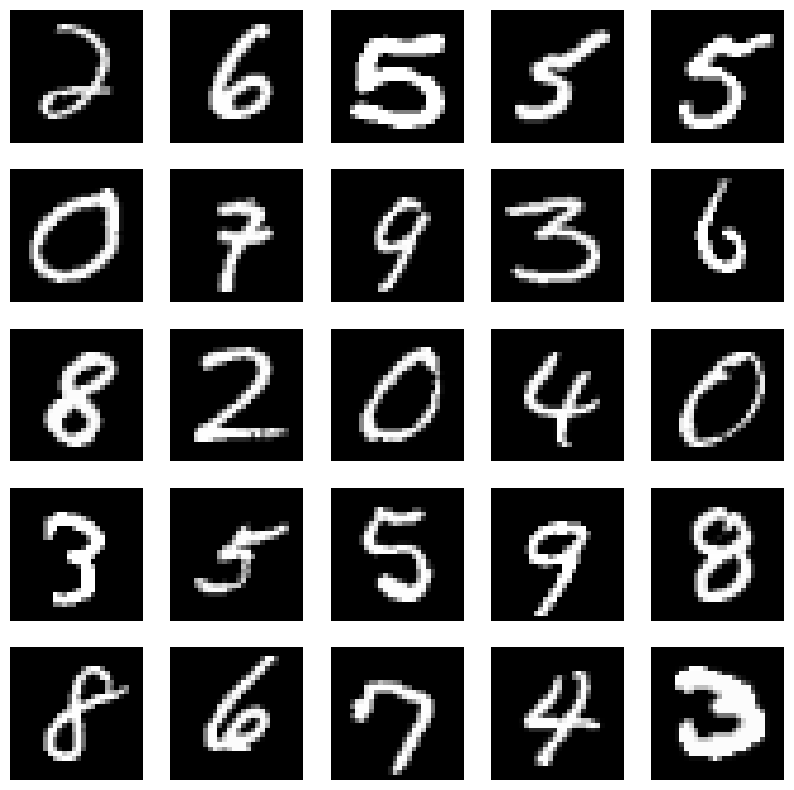

In [ ]:
import matplotlib.pyplot as plt
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].numpy().astype("float32").reshape(28, 28) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()
for image_batch in train_dataset.take(1):
    show_batch(image_batch)

In [ ]:
import matplotlib.pyplot as plt
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].numpy().astype("float32").reshape(28, 28) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()
for image_batch in train_dataset.take(1):
    show_batch(image_batch)

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*512, use_bias=False, input_shape=(100,)),  # Increased depth here
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 512)),  # Increased depth in the feature map
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),  # New layer
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model


def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model



In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
# Loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def pretrain_discriminator(discriminator, dataset, epochs=1):
    for epoch in range(epochs):
        for real_images in dataset:
            # Labels for real images
            real_labels = tf.ones((real_images.shape[0], 1))

            # Train the discriminator on real images
            discriminator.train_on_batch(real_images, real_labels)

# Pretrain the discriminator
pretrain_discriminator(discriminator, train_dataset, epochs=1)


In [ ]:
def train(dataset, epochs):

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())

        # Calculate average losses for the current epoch
        avg_gen_loss = sum(gen_loss_list) / len(gen_loss_list)
        avg_disc_loss = sum(disc_loss_list) / len(disc_loss_list)

        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}')


In [ ]:
EPOCHS = 1000  # Set the number of epochs according to your needs

# Assuming 'train_dataset' is already defined and preprocessed
train(train_dataset, EPOCHS)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/1000, Generator Loss: 6.6040, Discriminator Loss: 0.9863
Epoch 2/1000, Generator Loss: 11.6208, Discriminator Loss: 0.0455
Epoch 3/1000, Generator Loss: 6.7663, Discriminator Loss: 0.3886
Epoch 4/1000, Generator Loss: 5.6251, Discriminator Loss: 0.3309
Epoch 5/1000, Generator Loss: 4.9930, Discriminator Loss: 0.5098
Epoch 6/1000, Generator Loss: 4.0860, Discriminator Loss: 0.5138
Epoch 7/1000, Generator Loss: 3.5037, Discriminator Loss: 0.5888
Epoch 8/1000, Generator Loss: 3.1815, Discriminator Loss: 0.5887
Epoch 9/1000, Generator Loss: 2.9002, Discriminator Loss: 0.6246
Epoch 10/1000, Generator Loss: 3.1700, Discriminator Loss: 0.5988
Epoch 11/1000, Generator Loss: 2.7979, Discriminator Loss: 0.6159
Epoch 12/1000, Generator Loss: 2.7446, Discriminator Loss: 0.6264
Epoch 13/1000, Generator Loss: 2.7126, Discriminator Loss: 0.6559
Epoch 14/1000, Generator Loss: 2.6491, Discriminator Loss: 0.6681
Epoch 15/1000, Generator Loss: 2.6606, Discriminator Loss: 0.6715
Epoch 16/1000, Gen

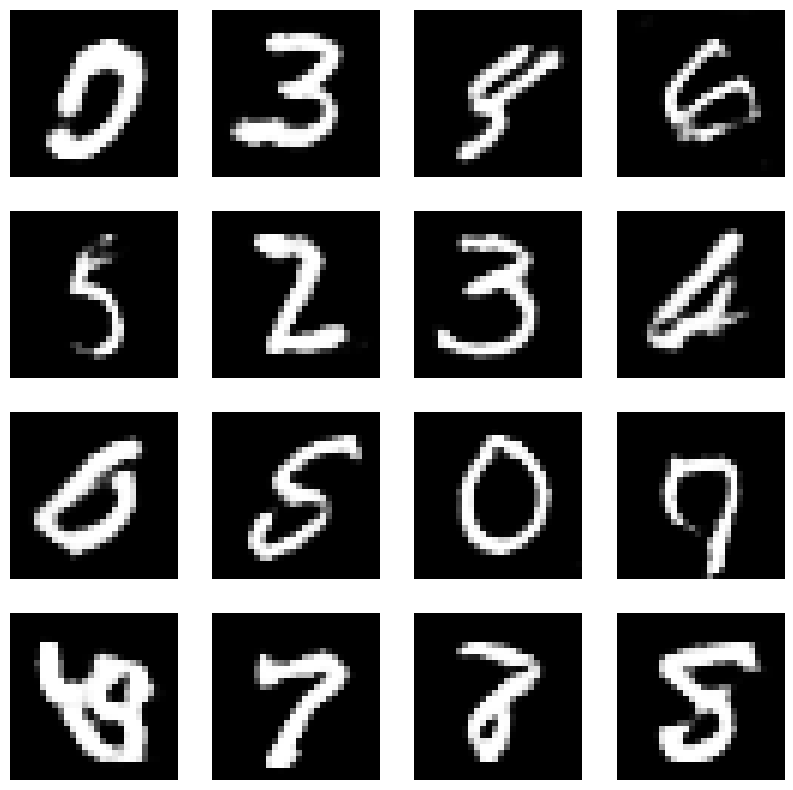

In [ ]:
import matplotlib.pyplot as plt

def generate_and_display_images(model, num_examples=16):
    noise = tf.random.normal([num_examples, 100])
    generated_images = model(noise, training=False)

    plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

generate_and_display_images(generator)